### GoogLeNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from dataset import mnist
from util import (
    get_torch_size_string,
    print_model_parameters,
    print_model_layers,
    model_train,
    model_eval,
    model_test
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Hyperparameters

In [2]:
device      = 'cpu' # cpu / mps
n_epoch     = 1
batch_size  = 128
print_every = 1
print ("Ready.")

Ready.


### Dataset

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
print ("MNIST ready.")

MNIST ready.


### Inception Blocks

In [4]:
class Inception(nn.Module):
    def __init__(self, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Activation
        self.actv = nn.ReLU()
        # Branch 1
        self.b1_1 = nn.LazyConv2d(c1, kernel_size=1)
        # Branch 2
        self.b2_1 = nn.LazyConv2d(c2[0], kernel_size=1)
        self.b2_2 = nn.LazyConv2d(c2[1], kernel_size=3, padding=1)
        # Branch 3
        self.b3_1 = nn.LazyConv2d(c3[0], kernel_size=1)
        self.b3_2 = nn.LazyConv2d(c3[1], kernel_size=5, padding=2)
        # Branch 4
        self.b4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.b4_2 = nn.LazyConv2d(c4, kernel_size=1)

    def forward(self, x):
        b1 = self.actv(self.b1_1(x)) 
        b2 = self.actv(self.b2_2(self.actv(self.b2_1(x)))) 
        b3 = self.actv(self.b3_2(self.actv(self.b3_1(x)))) 
        b4 = self.actv(self.b4_2(self.b4_1(x)))
        return th.cat((b1, b2, b3, b4), dim=1)
print ("Ready.")

Ready.


### GoogLeNet

In [5]:
class GoogLeNetClass(nn.Module):
    def __init__(
        self,
        name        = 'alexnet',
        x_dim       = (1,28,28),
        num_classes = 1000
    ):
        super(GoogLeNetClass,self).__init__()
        self.name        = name
        self.x_dim       = x_dim
        self.num_classes = num_classes
        
        self.net = nn.Sequential(
            self.b1(), 
            self.b2(), 
            self.b3(), 
            self.b4(), 
            self.b5(), 
            nn.LazyLinear(num_classes)
        )
        self.layer_names = []
        for l_idx,layer in enumerate(self.net):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
        
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    
    def b2(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=1), 
            nn.ReLU(),
            nn.LazyConv2d(192, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    
    def b3(self):
        return nn.Sequential(
            Inception(64, (96, 128), (16, 32), 32), 
            Inception(128, (128, 192), (32, 96), 64),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    
    def b4(self):
        return nn.Sequential(
            Inception(192, (96, 208), (16, 48), 64), 
            Inception(160, (112, 224), (24, 64), 64), 
            Inception(128, (128, 256), (24, 64), 64), 
            Inception(112, (144, 288), (32, 64), 64), 
            Inception(256, (160, 320), (32, 128), 128),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
    
    def b5(self):
        return nn.Sequential(
            Inception(256, (160, 320), (32, 128), 128), 
            Inception(384, (192, 384), (48, 128), 128), 
            nn.AdaptiveAvgPool2d((1,1)), 
            nn.Flatten()
        )
    
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyConv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm1d) or isinstance(m,nn.BatchNorm2d): 
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyLinear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
                
    def forward(self,x):
        """
            Forward propagate
        """
        intermediate_output_list = []
        for layer in self.net:
            x = layer(x)
            intermediate_output_list.append(x)
        final_output = x
        return final_output,intermediate_output_list
    
print ("Ready.")        

Ready.


In [6]:
googlenet = GoogLeNetClass(
    num_classes = 1000
).to(device)
loss = nn.CrossEntropyLoss()
optm = th.optim.Adam(googlenet.parameters(),lr=1e-3)
print ("Ready.")

Ready.


/Users/sj/anaconda3/envs/mujoco/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


### Print model layers

In [7]:
x_torch = th.randn((16,)+googlenet.x_dim).to(device)
print_model_layers(googlenet,x_torch)

batch_size:[16]
[  ] layer:[          input] size:[    16x1x28x28]
[ 0] layer:[  sequential_00] size:[     16x64x7x7] numel:[     50176]
[ 1] layer:[  sequential_01] size:[    16x192x4x4] numel:[     49152]
[ 2] layer:[  sequential_02] size:[    16x480x2x2] numel:[     30720]
[ 3] layer:[  sequential_03] size:[    16x832x1x1] numel:[     13312]
[ 4] layer:[  sequential_04] size:[       16x1024] numel:[     16384]
[ 5] layer:[  lazylinear_05] size:[       16x1000] numel:[     16000]


### Print model parameters

In [8]:
print_model_parameters(googlenet)

[ 0] parameter:[             net.0.0.weight] shape:[    64x1x7x7] numel:[      3136]
[ 1] parameter:[               net.0.0.bias] shape:[          64] numel:[        64]
[ 2] parameter:[             net.1.0.weight] shape:[   64x64x1x1] numel:[      4096]
[ 3] parameter:[               net.1.0.bias] shape:[          64] numel:[        64]
[ 4] parameter:[             net.1.2.weight] shape:[  192x64x3x3] numel:[    110592]
[ 5] parameter:[               net.1.2.bias] shape:[         192] numel:[       192]
[ 6] parameter:[        net.2.0.b1_1.weight] shape:[  64x192x1x1] numel:[     12288]
[ 7] parameter:[          net.2.0.b1_1.bias] shape:[          64] numel:[        64]
[ 8] parameter:[        net.2.0.b2_1.weight] shape:[  96x192x1x1] numel:[     18432]
[ 9] parameter:[          net.2.0.b2_1.bias] shape:[          96] numel:[        96]
[10] parameter:[        net.2.0.b2_2.weight] shape:[  128x96x3x3] numel:[    110592]
[11] parameter:[          net.2.0.b2_2.bias] shape:[         128]

### Train GoogLeNet

In [9]:
model_train(googlenet,optm,loss,train_iter,test_iter,n_epoch,print_every,device)

epoch:[ 0/1] loss:[0.675] train_accr:[0.9478] test_accr:[0.9531].


### Test GoogLeNet

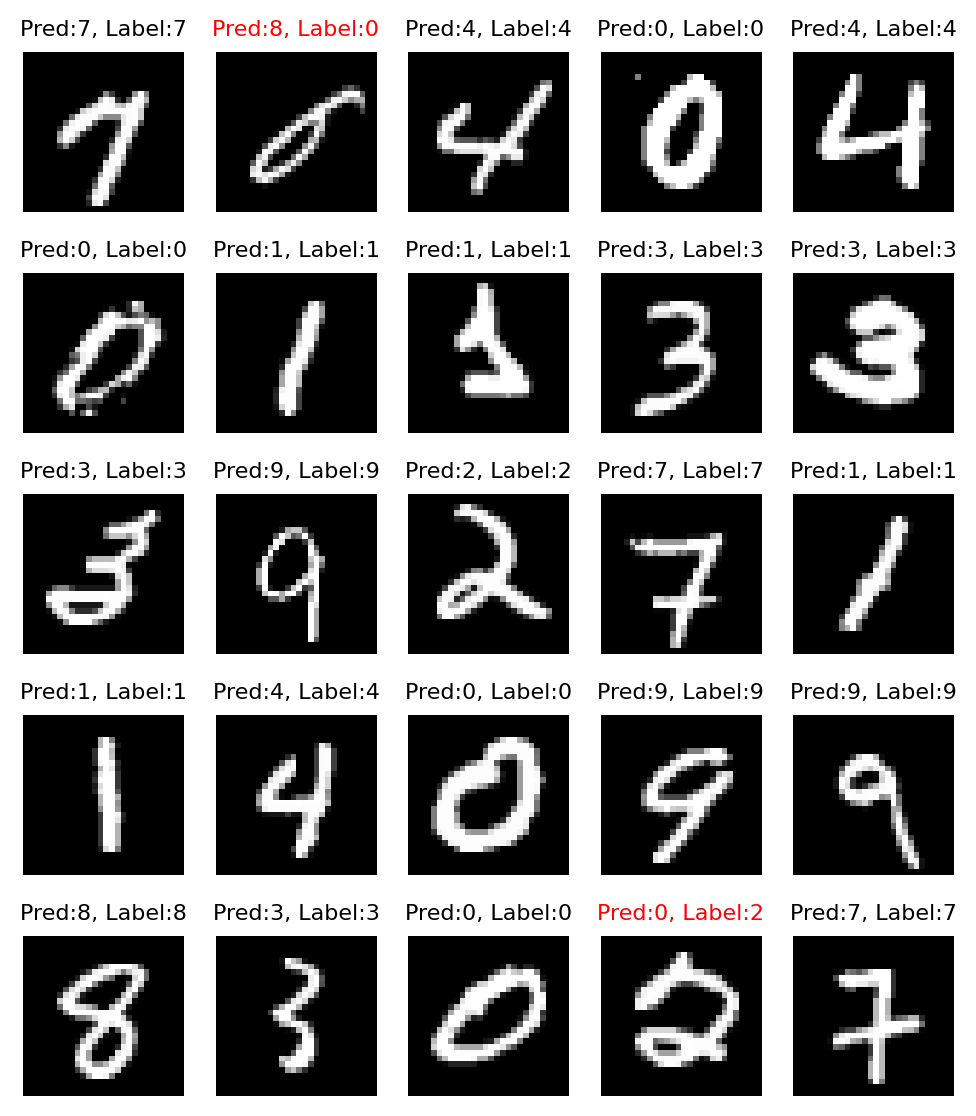

In [10]:
model_test(googlenet,test_data,test_label,device)